In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import os
from sklearn.model_selection import train_test_split

%matplotlib inline

pd.options.display.max_colwidth = -1

This notebook is for Chapter 3 Exercise 4, build a spam classifier.

I got the spam data from Spam Assassin: http://csmining.org/index.php/spam-assassin-datasets.html

## Load Data

In [6]:
def text_files_to_df(target_dir, label):
    """
    Puts all of the text files in target_dir into a dataframe. The first column is the text, the second column
    is the label.
    """
    t = []
    filelist = os.listdir(target_dir)
    for f in filelist:
        target_file = os.path.join(target_dir, f)
        with open(target_file, 'r') as myfile:
            t.append(myfile.read())
    df = pd.DataFrame({'text':t, 'label':label})
    return df



In [ ]:
    
spam_path = 'datasets/spam'
easy_ham_df = text_files_to_df(spam_path+'/easy_ham', 'easy_ham')
hard_ham_df = text_files_to_df(spam_path+'/hard_ham', 'hard_ham')
spam_df     = text_files_to_df(spam_path+'/spam', 'spam')

df = pd.concat([easy_ham_df, hard_ham_df, spam_df])
df.columns = ['desc', 'text']
df['label'] = df.desc.replace(['easy_ham', 'hard_ham', 'spam'], [0,0,1])

In [14]:
# Check class balance
df.label.value_counts(normalize=True)

0    0.848274
1    0.151726
Name: label, dtype: float64

In [21]:
perm_idx = np.random.permutation(df.index)
df = df.loc[perm_idx]

X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, train_size=.8)

## EDA

In [23]:
X_train.head()

368    From fork-admin@xent.com  Mon Aug 26 19:54:53 2002\nReturn-Path: <fork-admin@xent.com>\nDelivered-To: yyyy@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id A126543F99\n\tfor <jm@localhost>; Mon, 26 Aug 2002 14:54:52 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Mon, 26 Aug 2002 19:54:52 +0100 (IST)\nReceived: from xent.com ([64.161.22.236]) by dogma.slashnull.org\n    (8.11.6/8.11.6) with ESMTP id g7QIlbZ05026 for <jm@jmason.org>;\n    Mon, 26 Aug 2002 19:47:37 +0100\nReceived: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)\n    with ESMTP id 168A62941BE; Mon, 26 Aug 2002 11:42:11 -0700 (PDT)\nDelivered-To: fork@example.com\nReceived: from t2.serverbox.net (t2.serverbox.net [64.71.187.100]) by\n    xent.com (Postfix) with SMTP id D8BBA294182 for <fork@xent.com>;\n    Mon, 26 Aug 2002 11:41:58 -0700 (P

## Modeling

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Preprocessing

In [28]:
# revisit: punctuation, stopwords, URLs, numbers, n_grams, etc
# extras: count length of each doc, look at caps/lowercase

preprocess_pipeline = Pipeline([
                        #('tfidf', TfidfVectorizer(max_df = .9))
                        ('count_vec', CountVectorizer(binary=True, max_df = .9, decode_error='ignore'))
    ])

## Train Models

### Naive Bayes

In [29]:
nb_pipeline = Pipeline([
                            ('prep', preprocess_pipeline),
                            ('nb', BernoulliNB())
    ])

nb_cv = GridSearchCV(nb_pipeline, param_grid={}, cv=4, n_jobs=-1, scoring='roc_auc')
nb_cv.fit(X_train, y_train)
print nb_cv.grid_scores_

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('prep', Pipeline(steps=[('count_vec', CountVectorizer(analyzer=u'word', binary=True, decode_error='ignore',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,...ocabulary=None))])), ('nb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### SVM

In [30]:
svm_pipeline = Pipeline([
                            ('tfidf', TfidfVectorizer(max_df = .9, decode_error='ignore')),
                            ('svm', SVC(kernel='linear')),
    ])

svm_cv = GridSearchCV(svm_pipeline, param_grid={'svm__C':[.03, .1, .3, 1]}, cv=3, n_jobs=-1, scoring='roc_auc')
svm_cv.fit(X_train, y_train)
print svm_cv.best_params_
print svm_cv.grid_scores_

{'svm__C': 1}
[mean: 0.97314, std: 0.00174, params: {'svm__C': 0.03}, mean: 0.99396, std: 0.00055, params: {'svm__C': 0.1}, mean: 0.99915, std: 0.00016, params: {'svm__C': 0.3}, mean: 0.99983, std: 0.00005, params: {'svm__C': 1}]


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Random Forest

In [31]:
rf_pipeline = Pipeline([
                            ('prep', preprocess_pipeline),
                            ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
    ])

rf_cv = GridSearchCV(rf_pipeline, param_grid={'rf__min_samples_leaf':[1,3,9,30]}, cv=4, n_jobs=-1, scoring='roc_auc')
rf_cv.fit(X_train, y_train)
print rf_cv.best_params_

{'rf__min_samples_leaf': 1}


## Evalute models

In [32]:
def print_model_metrics(cv_object, model_name):
    if hasattr(cv_object, 'predict_proba'):
        scores = cv_object.predict_proba(X_train)[:,1]
    else:
        scores = cv_object.decision_function(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, scores)
    print model_name.upper()
    print 'Best average ROC score: %f' % cv_object.best_score_
    print 'Accuracy on test data: %f\n' % accuracy_score(y_test, cv_object.predict(X_test))
    plt.plot(fpr, tpr, label=model_name)
    plt.title('ROC Curve for Training Data')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend()

    
def plot_feature_importances(feature_importance, vocab, n_features):
    """
    Makes a barplot of the top n features and their feature_importances (a la random forest)
    feature_importance: list or array of values
    vocab: list or array of words
    n_features: number of features to plot
    """
    assert len(feature_importance) == len(vocab), 'feature_importance and vocab must be of equal length'
    if isinstance(feature_importance, list):
        feature_importance = np.array(feature_importance)
    if isinstance(vocab, list):
        vocab = np.array(vocab)
    
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_feature_importance = feature_importance[sorted_idx][-n_features:]
    sorted_vocab = vocab[sorted_idx][-n_features:]
    pos = np.arange(n_features) + .5
    fig = plt.figure(figsize=(5, n_features/3))
    plt.barh(pos, sorted_feature_importance, align='center')
    plt.yticks(pos, sorted_vocab)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    
    

NAIVE BAYES
Best average ROC score: 0.996759
Accuracy on test data: 0.980207

SVM
Best average ROC score: 0.999829
Accuracy on test data: 0.994345

RF
Best average ROC score: 0.999995
Accuracy on test data: 0.998115



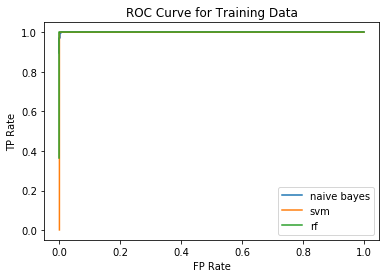

In [33]:
print_model_metrics(nb_cv, 'naive bayes')
print_model_metrics(svm_cv, 'svm')
print_model_metrics(rf_cv, 'rf')

## Which words are most predictive?

### In Random Forest:

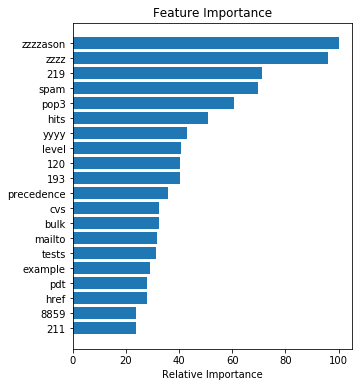

In [34]:
feature_importance = rf_cv.best_estimator_.named_steps['rf'].feature_importances_
vocab = rf_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].get_feature_names()
plot_feature_importances(feature_importance, vocab, 20)

## Notes:  
Should my accuracy be this good??? I didn't even have to do any data cleaning or feature engineering...

Potential ideas:  
- finish the section below on "digging into naive bayes results"  
-- plot conditional probs with NB like I plotted feature importances with RF  
-- consider that I already wrote functions at Metis for showing feature importances and sorting coefficients...  
-- write a function that lets me input some text and find out which words from my models are contributing the most to my predictions

In [35]:
vocab = nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].get_feature_names()
cond_probs = np.exp(nb_cv.best_estimator_.named_steps['nb'].feature_log_prob_)
spam_ham_ratio = cond_probs[1,:]/cond_probs[0,:]
labeled_ratios = zip(vocab, spam_ham_ratio)
sorted_labeled_ratios = sorted(labeled_ratios, key=lambda x: x[1])

In [36]:
print 'Words much more common in spam than ham:'
pprint.pprint(sorted_labeled_ratios[-20:])

Words much more common in spam than ham:
[(u'btamail', 114.33628318584071),
 (u'1600', 125.45231071779745),
 (u'2462', 146.09636184857428),
 (u'attained', 146.09636184857428),
 (u'progid', 165.15240904621442),
 (u'btnsubmit', 171.50442477876109),
 (u'1900', 181.03244837758118),
 (u'304704', 190.56047197640115),
 (u'contactname', 190.56047197640115),
 (u'hdnrecipienttxt', 190.56047197640115),
 (u'hdnsubjecttxt', 190.56047197640115),
 (u'insiq', 190.56047197640115),
 (u'6b01a8c0', 196.91248770894794),
 (u'host66', 196.91248770894794),
 (u'iiq', 196.91248770894794),
 (u'insuranceiq', 196.91248770894794),
 (u'optout', 235.02458210422827),
 (u'rly', 295.36873156342193),
 (u'efi', 511.33726647000998),
 (u'zzzzason', 1416.4995083579158)]


In [37]:
print 'Words much more common in ham than spam:'
pprint.pprint(sorted_labeled_ratios[:20])

Words much more common in ham than spam:
[(u'cvs', 0.0016388069485414618),
 (u'yyyy', 0.0017743060705437724),
 (u'known_mailing_list', 0.0024890343779571736),
 (u'awl', 0.0025990244404855583),
 (u'wrote', 0.0035132830379130029),
 (u'in_rep_to', 0.0041625266923635048),
 (u'fork', 0.0041955189779040352),
 (u'xent', 0.0042122120242352162),
 (u'lair', 0.0042290384371149858),
 (u'khare', 0.0042459998212210593),
 (u'rohit', 0.0042459998212210593),
 (u'hits', 0.0047051968389234889),
 (u'quoted_email_text', 0.0050015871909816585),
 (u'rssfeeds', 0.0059811824223603644),
 (u'tests', 0.0063967932855455243),
 (u'spam_phrase_00_01', 0.0071370963287041653),
 (u'pyzor', 0.007561923491127033),
 (u'email_attribution', 0.0076530310030683254),
 (u'redhat', 0.0086776171209654498),
 (u'qqqqqqqqqq', 0.0098633784666874308)]


In [39]:
test['pred'] = nb_cv.predict(X_test)

NameError: name 'test' is not defined

In [ ]:
test[test.label==1].iloc[:20,:]

In [117]:
for w, p in labeled_ratios:
    if w == 'call':
        print w, p

call 10.1586904788


In [118]:
test_array = nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].transform(test.text[51:53]). \
    todense()[0,:]
test_array = np.asarray(test_array).flatten()

In [119]:
np.array(labeled_ratios)[test_array==1, :]

array([[u'0870', u'51.5444839858'],
       [u'08707509020', u'38.6583629893'],
       [u'1327', u'45.1014234875'],
       [u'20p', u'57.987544484'],
       [u'5wb', u'45.1014234875'],
       [u'box', u'24.6983985765'],
       [u'call', u'10.1586904788'],
       [u'cr9', u'45.1014234875'],
       [u'croydon', u'45.1014234875'],
       [u'fantasies', u'38.6583629893'],
       [u'hot', u'15.4633451957'],
       [u'is', u'1.44898522122'],
       [u'just', u'1.97299460233'],
       [u'live', u'9.37172436105'],
       [u'ltd', u'90.2028469751'],
       [u'min', u'10.3804863582'],
       [u'national', u'103.088967972'],
       [u'now', u'4.30513587836'],
       [u'ntt', u'51.5444839858'],
       [u'per', u'20.5006470398'],
       [u'po', u'47.2491103203'],
       [u'rate', u'49.396797153']],
      dtype='<U28')

In [83]:
np.array(labeled_ratios)[test_array.T==1, :]

IndexError: too many indices for array

In [107]:
labeled_ratios[:10]

[(u'raining', 64.430604982206404),
 (u'todays', 154.63345195729536),
 (u'msgs', 19.329181494661924),
 (u'yellow', 12.88612099644128),
 (u'150ppermesssubscription', 12.88612099644128),
 (u'four', 12.88612099644128),
 (u'nottingham', 12.88612099644128),
 (u'woods', 3.2215302491103195),
 (u'asian', 38.65836298932382),
 (u'hanging', 25.772241992882563)]

In [103]:
test.text[51:53]

51    HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call
52    on a Tuesday night r u 4 real                                                                                             
Name: text, dtype: object

In [110]:
np.array(vocab)[test_array==1]

array([u'fingers', u'china', u'rt', u'olage', u'vitamin', u'b4190604',
       u'spare', u'appointment', u'08717205546', u'location', u'asks',
       u'forgiven', u'granite', u'fall', u'08000839402', u'aquarius',
       u'thgt', u'convincing', u'paces', u'applausestore', u'bahamas',
       u'downloads'],
      dtype='<U28')

In [111]:
nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].vocabulary_

{u'raining': 5357,
 u'todays': 6716,
 u'msgs': 4453,
 u'yellow': 7453,
 u'150ppermesssubscription': 295,
 u'four': 2844,
 u'nottingham': 4662,
 u'woods': 7352,
 u'asian': 1037,
 u'hanging': 3190,
 u'6pm': 578,
 u'captain': 1577,
 u'6ph': 577,
 u'esplanade': 2527,
 u'increase': 3519,
 u'buddy': 1485,
 u'electricity': 2449,
 u'scold': 5744,
 u'seriously': 5826,
 u'presents': 5202,
 u'swat': 6429,
 u'unnecessarily': 6949,
 u'lord': 4052,
 u'rp176781': 5635,
 u'savings': 5724,
 u'sleepingwith': 6015,
 u'delhi': 2137,
 u'callin': 1552,
 u'kudi': 3833,
 u'61200': 549,
 u'sufficient': 6364,
 u'chik': 1709,
 u'neway': 4586,
 u'hearin': 3251,
 u'screaming': 5758,
 u'disturb': 2255,
 u'prize': 5234,
 u'andre': 910,
 u'skills': 5997,
 u'companies': 1839,
 u'wednesday': 7200,
 u'lst': 4092,
 u'heading': 3243,
 u'clothes': 1776,
 u'10k': 258,
 u'force': 2818,
 u'specially': 6155,
 u'nigh': 4602,
 u'tired': 6687,
 u'snuggles': 6069,
 u'clubmoby': 1780,
 u'japanese': 3659,
 u'elections': 2448,
 u'sec

In [113]:
nb_cv.best_estimator_.named_steps['prep'].named_steps['count_vec'].get_feature_names()

[u'00',
 u'000',
 u'008704050406',
 u'0089',
 u'0121',
 u'01223585236',
 u'01223585334',
 u'0125698789',
 u'02',
 u'0207',
 u'02072069400',
 u'02073162414',
 u'02085076972',
 u'021',
 u'03',
 u'04',
 u'05',
 u'050703',
 u'0578',
 u'06',
 u'07',
 u'07008009200',
 u'07046744435',
 u'07090298926',
 u'07099833605',
 u'07123456789',
 u'0721072',
 u'07734396839',
 u'07753741225',
 u'0776xxxxxxx',
 u'07781482378',
 u'07786200117',
 u'077xxx',
 u'078',
 u'07808247860',
 u'07808726822',
 u'07815296484',
 u'07821230901',
 u'078498',
 u'07880867867',
 u'07946746291',
 u'0796xxxxxx',
 u'07973788240',
 u'07xxxxxxxxx',
 u'08',
 u'0800',
 u'08000407165',
 u'08000776320',
 u'08000839402',
 u'08000930705',
 u'08000938767',
 u'08001950382',
 u'08002888812',
 u'08002986030',
 u'08002986906',
 u'08002988890',
 u'08006344447',
 u'0808',
 u'08081263000',
 u'08081560665',
 u'0825',
 u'083',
 u'0844',
 u'08448350055',
 u'08448714184',
 u'0845',
 u'08452810073',
 u'08452810075over18',
 u'0870',
 u'08700469649'